In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    hour = 'y-m-d-hour'
    month = 'month'
    status = 'status'

file_list = os.listdir('Data/data_per_machine/2022/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C609.csv', '15

In [2]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [3]:
mach_index = 10

In [4]:
df = pd.read_csv('Data/data_per_machine/2022/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
df[ColumnsOutput.hour] = df[ColumnsInput.time].dt.strftime('%y-%m-%d-%H')
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode  ddc_mch_code ddc_mch_side            ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day   y-m-d-hour
0          30   9439621354       42584          1302            R       UN_UNLOADER_UP_STOP 2022-10-10 00:00:01      False     10  22-10-10  22-10-10-00
1          31   9439621354       42584          1302            R     UN_UNLOADER_OUT_START 2022-10-10 00:00:01      False     10  22-10-10  22-10-10-00
2          58   9439621379       42584          1302            R  LO_LOADER_IN_PRESS_START 2022-10-10 00:00:04      False     10  22-10-10  22-10-10-00
3          59   9439621354       42584          1302            R      UN_UNLOADER_OUT_STOP 2022-10-10 00:00:04      False     10  22-10-10  22-10-10-00
4         100   9439621379       42584          1302            R   LO_LOADER_IN_PRESS_STOP 2022-10-10 00:00:09      False     10  22-10-10  22-10-10-00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424673 entries, 0 to 424672
Data

In [5]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(52, 4)
    y-m-day                 min                 max  work_time
0  22-10-10 2022-10-10 00:00:01 2022-10-10 23:53:50    86029.0
1  22-10-11 2022-10-11 00:08:15 2022-10-11 23:53:22    85507.0
2  22-10-12 2022-10-12 00:02:00 2022-10-12 23:48:48    85608.0
3  22-10-13 2022-10-13 00:00:30 2022-10-13 23:51:02    85832.0
4  22-10-14 2022-10-14 00:00:00 2022-10-14 23:48:43    85723.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-10            L 2022-10-10 00:13:43 2022-10-10 23:53:50    85207.0
1  22-10-10            R 2022-10-10 00:00:01 2022-10-10 23:51:21    85880.0
2  22-10-11            L 2022-10-11 00:08:24 2022-10-11 23:47:26    85142.0
3  22-10-11            R 2022-10-11 00:08:15 2022-10-11 23:53:22    85507.0
4  22-10-12            L 2022-10-12 00:02:00 2022-10-12 23:45:54    85434.0


(50, 5)

In [6]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(52, 2)
(102, 3)


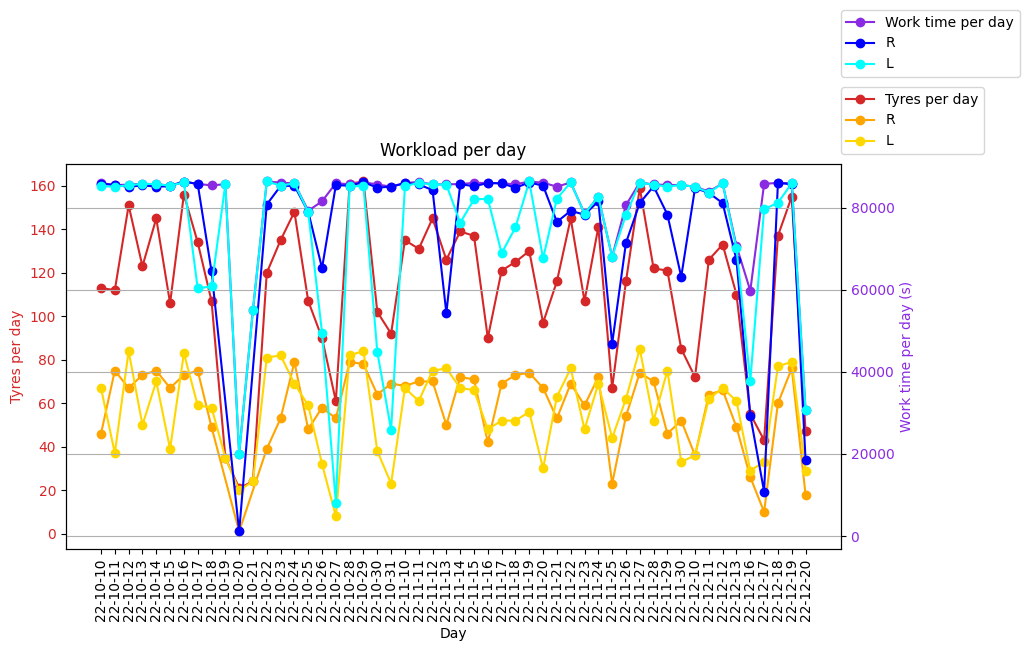

In [7]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title('Workload per day')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

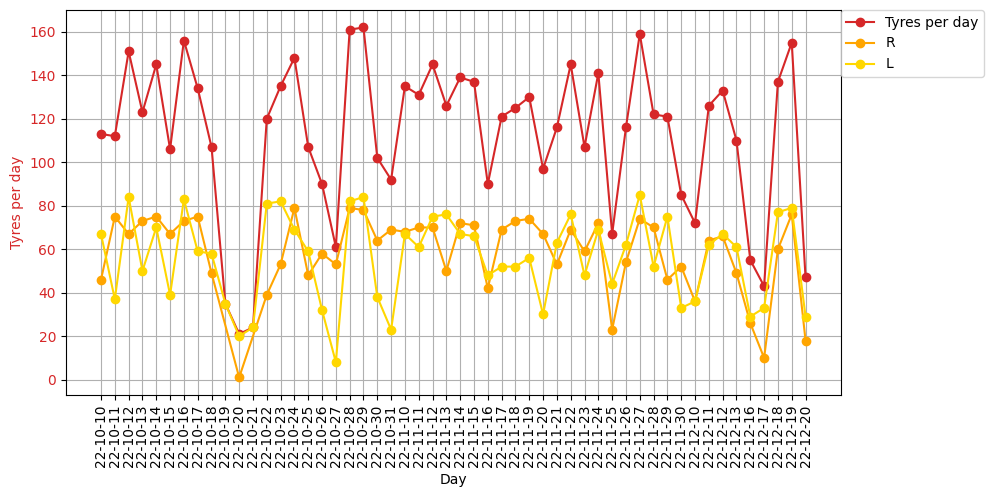

In [8]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

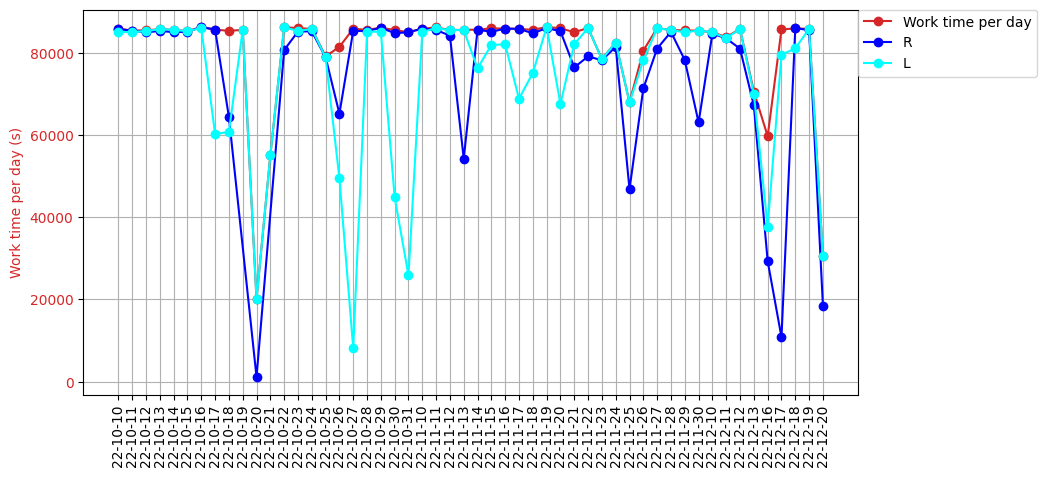

In [9]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [10]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [11]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.day].nunique()

52

In [12]:
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

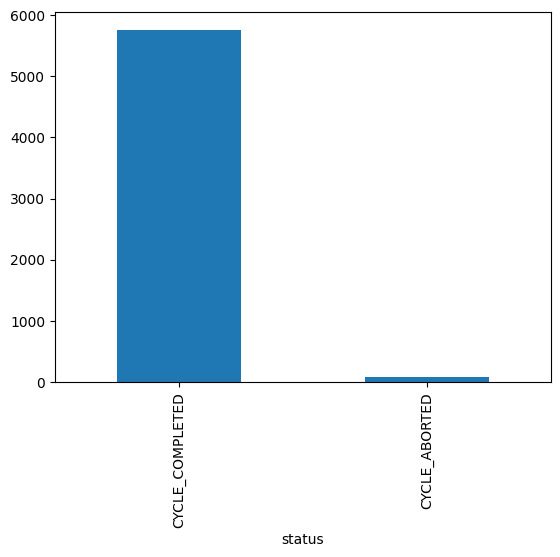

In [13]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

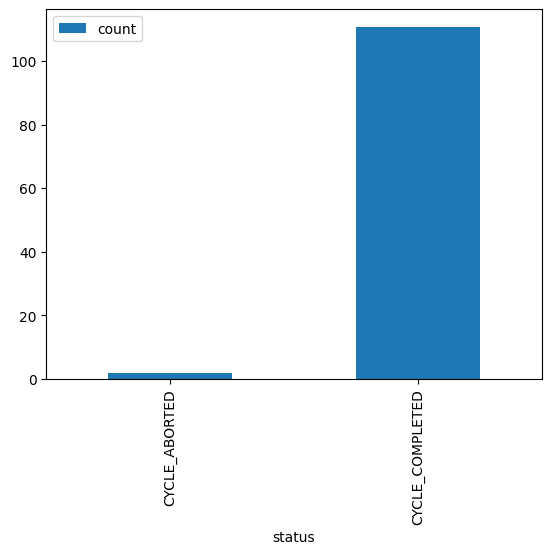

In [14]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [15]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day[status] = 0
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

CYCLE_NOT_STARTED not in columns
52
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-10              2              111                  0
1       22-10-11              2              110                  0
2       22-10-12              2              149                  0
3       22-10-13              1              122                  0
4       22-10-14              2              143                  0
(52, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(52, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(52, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


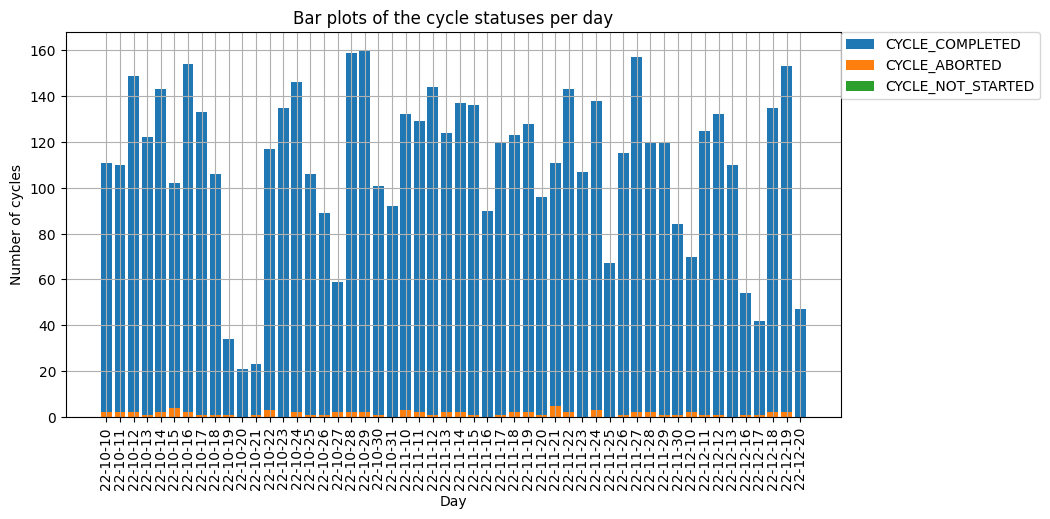

In [16]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [17]:
# label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
# label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
# cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_left = []
# for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
#     statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_left:
#     print(i.shape)
#     print('\n')
# cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_right = []
# for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
#     statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_right:
#     print(i.shape)
#     print('\n')


# cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
# cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
# cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
# for status in status_names:
#     if status not in cycle_statuses_per_day_left.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_left[status] = 0
#     if status not in cycle_statuses_per_day_right.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_right[status] = 0
# print(cycle_statuses_per_day_right)




In [18]:
cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day_left.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_left[status] = 0
    if status not in cycle_statuses_per_day_right.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_right[status] = 0
statuses_per_day_left = []
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_left:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')
statuses_per_day_right = []    
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_right:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

CYCLE_NOT_STARTED not in columns
CYCLE_NOT_STARTED not in columns
(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(50, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(50, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status'

3


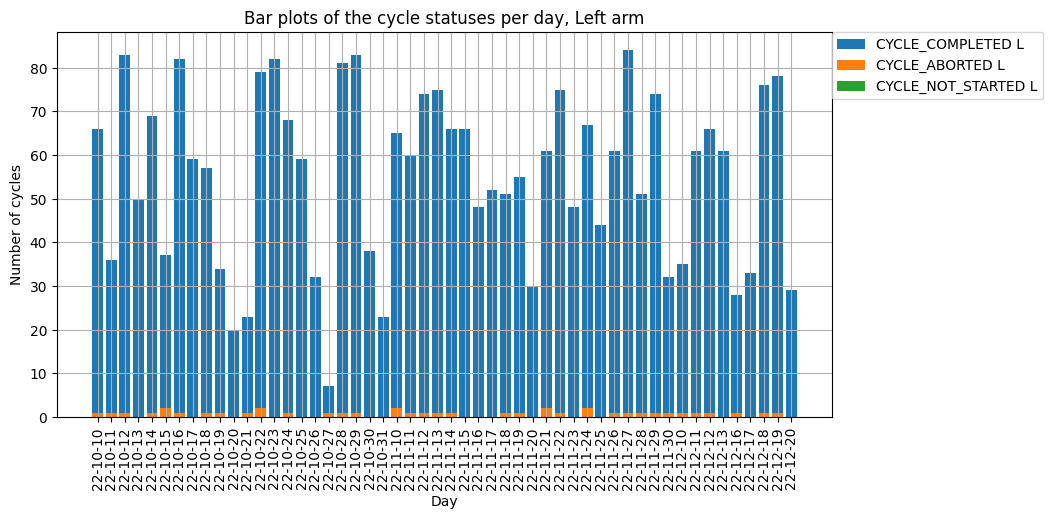

In [19]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

52


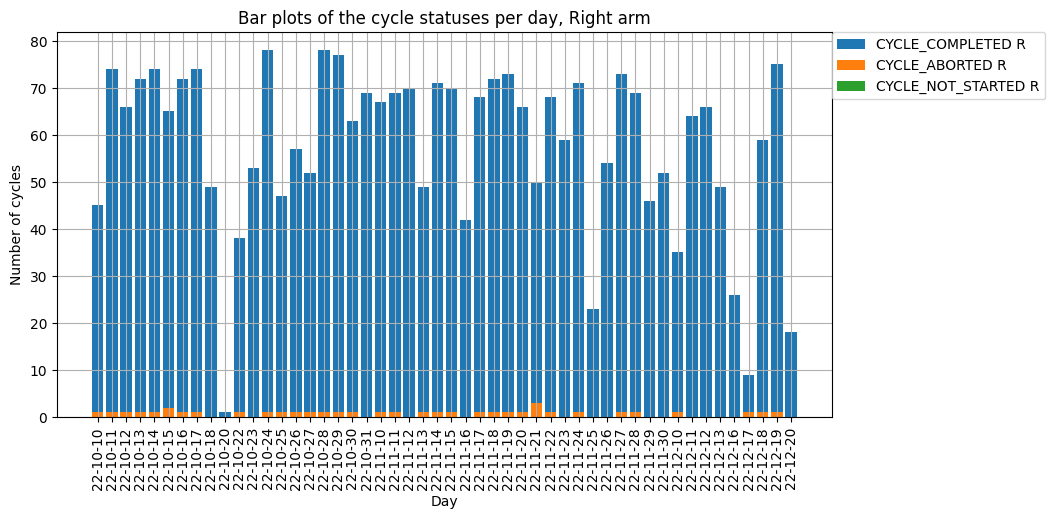

In [20]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [21]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

## Getting all previous indices per day fro the machines

In [22]:

len(days)



52

In [23]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-10,113,67,46.0,86029.0,85207.0,85880.0,66,1,0,45.0,1.0,0.0,111,2,0
1,22-10-11,112,37,75.0,85507.0,85142.0,85507.0,36,1,0,74.0,1.0,0.0,110,2,0
2,22-10-12,151,84,67.0,85608.0,85434.0,85109.0,83,1,0,66.0,1.0,0.0,149,2,0
3,22-10-13,123,50,73.0,85832.0,85832.0,85430.0,50,0,0,72.0,1.0,0.0,122,1,0
4,22-10-14,145,70,75.0,85723.0,85723.0,85152.0,69,1,0,74.0,1.0,0.0,143,2,0
5,22-10-15,106,39,67.0,85385.0,85366.0,85223.0,37,2,0,65.0,2.0,0.0,102,4,0
6,22-10-16,156,83,73.0,86377.0,86160.0,86377.0,82,1,0,72.0,1.0,0.0,154,2,0
7,22-10-17,134,59,75.0,85773.0,60348.0,85773.0,59,0,0,74.0,1.0,0.0,133,1,0
8,22-10-18,107,58,49.0,85457.0,60817.0,64489.0,57,1,0,49.0,0.0,0.0,106,1,0
9,22-10-19,35,35,1.0,85705.0,85705.0,1108.0,34,1,0,1.0,0.0,0.0,34,1,0


<Axes: >

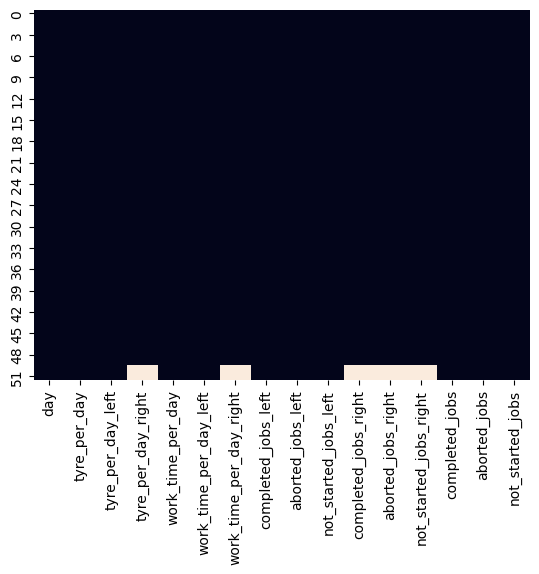

In [24]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

In [25]:
mach_processed_df = mach_processed_df.fillna(0)

### Correlation between the tyres produced and the completed cycles

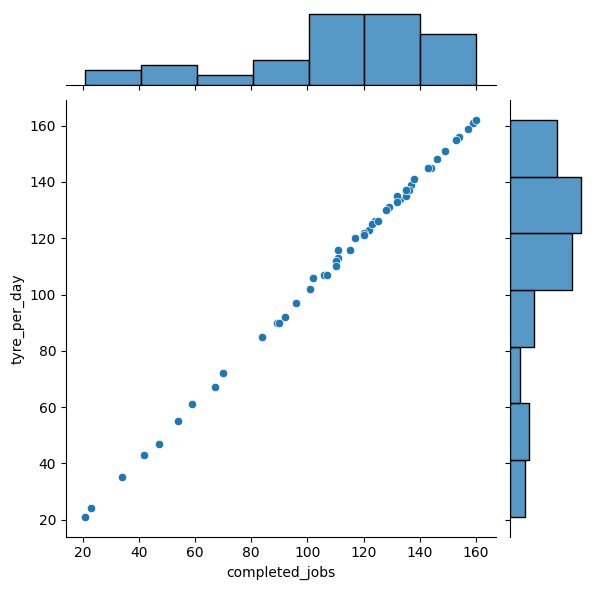

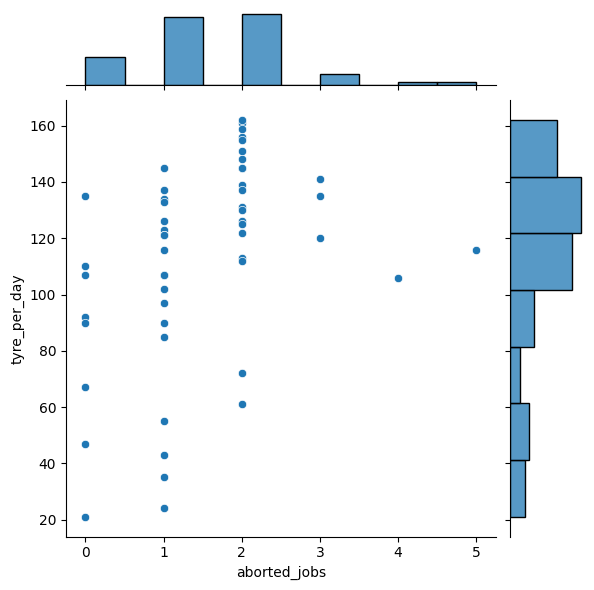

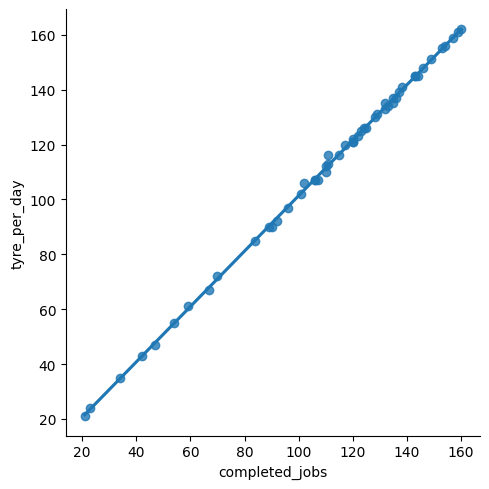

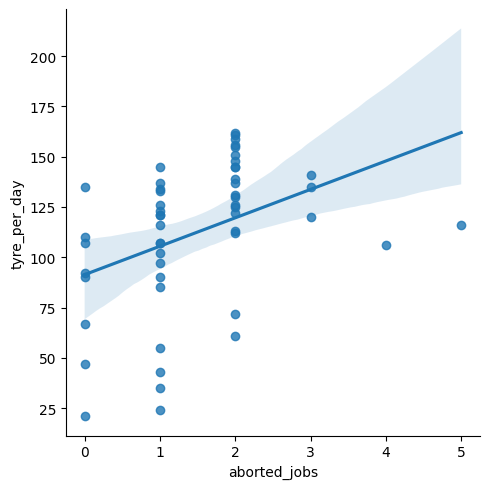

In [26]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

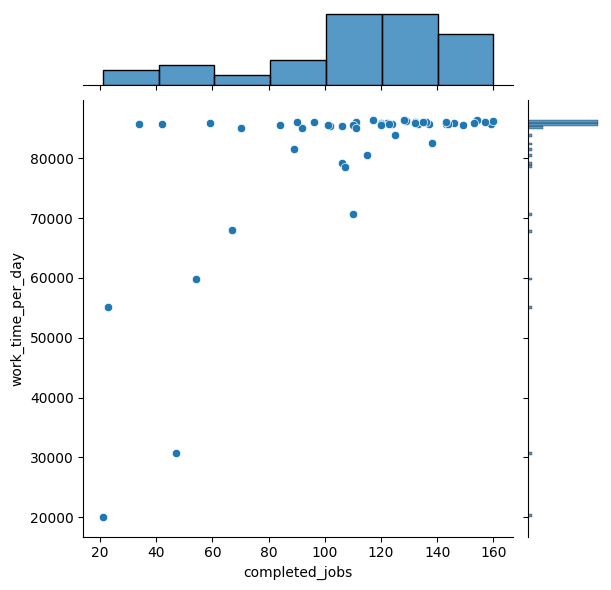

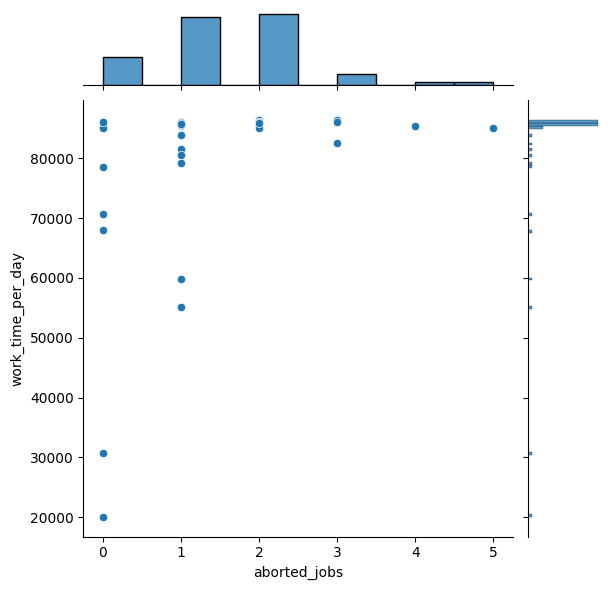

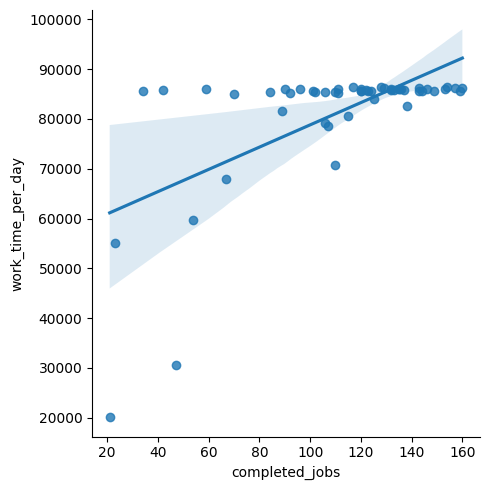

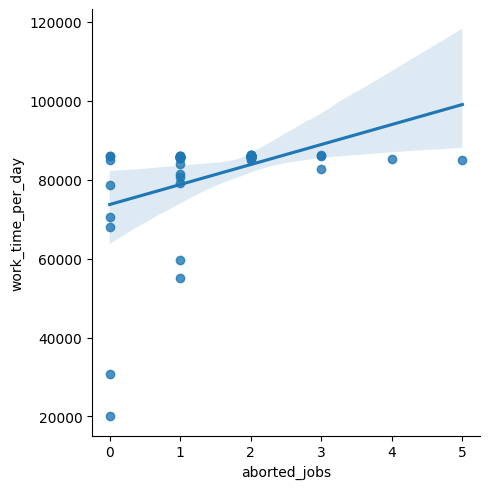

In [27]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

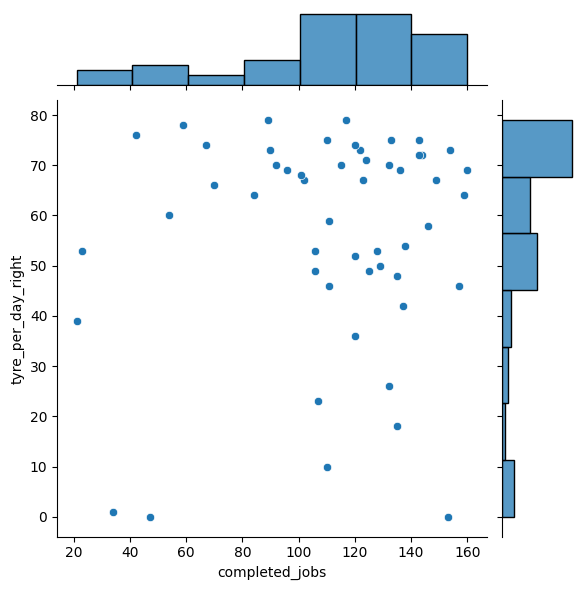

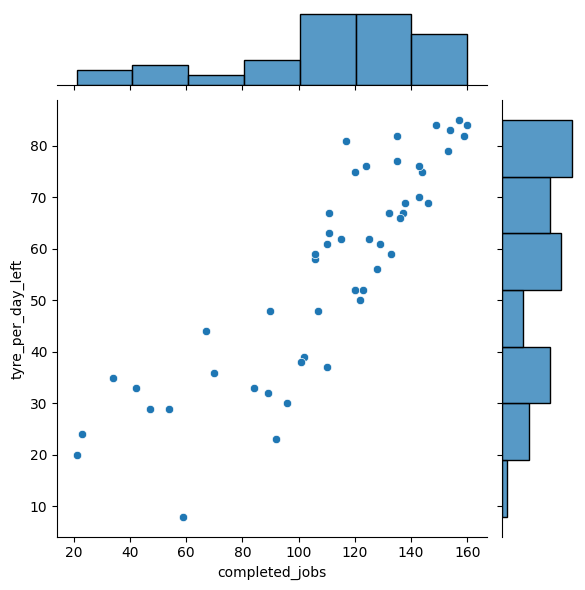

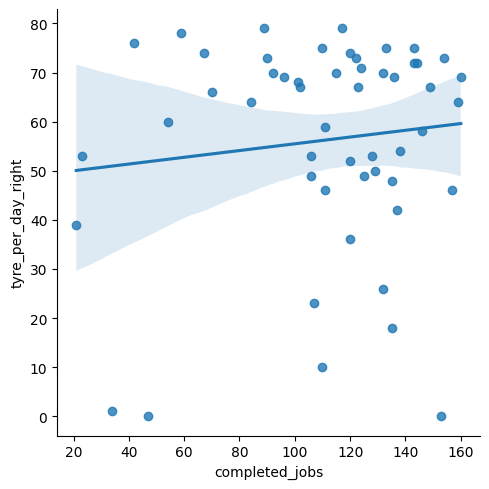

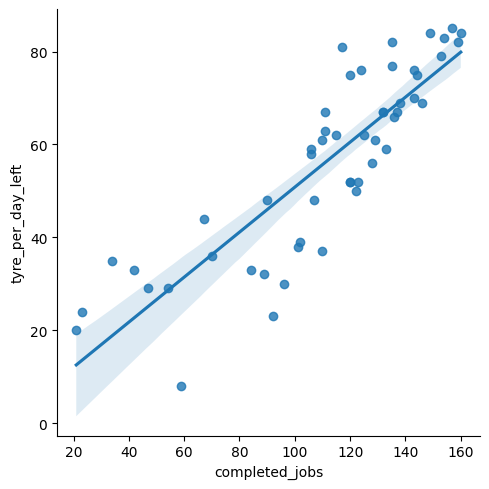

In [28]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

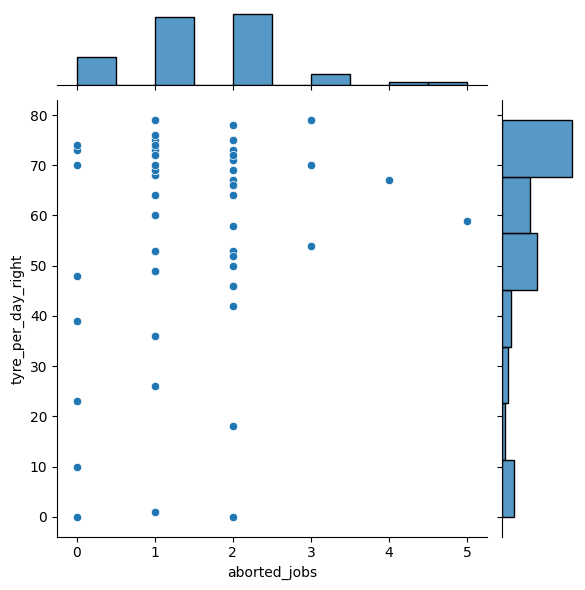

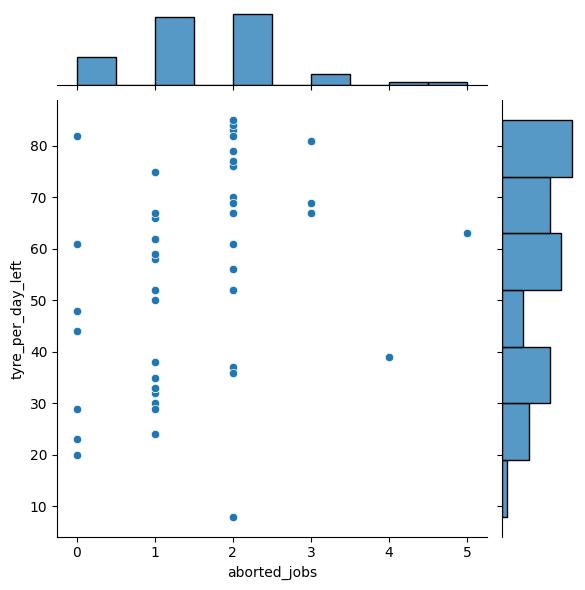

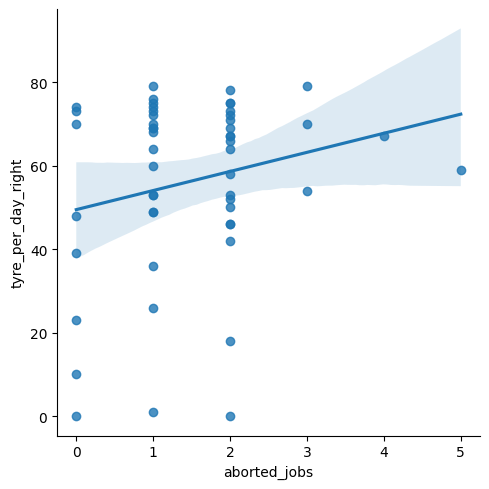

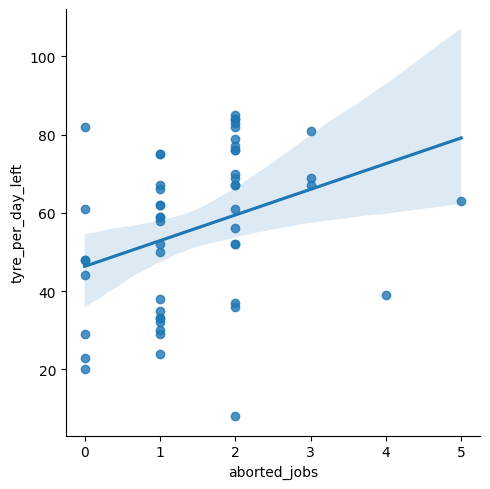

In [29]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


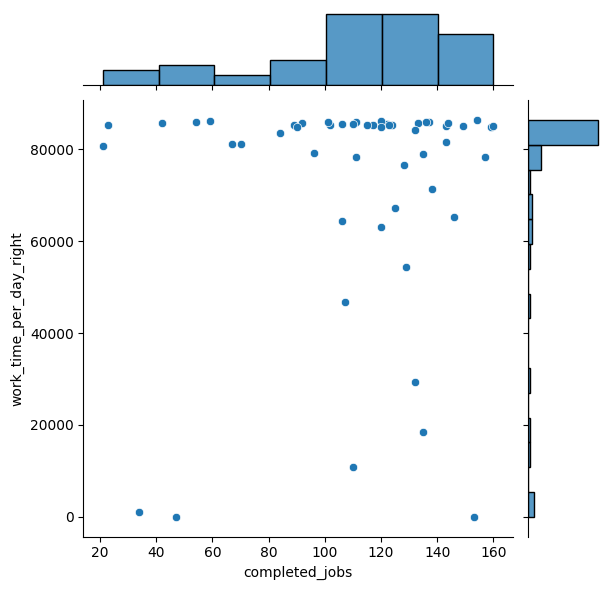

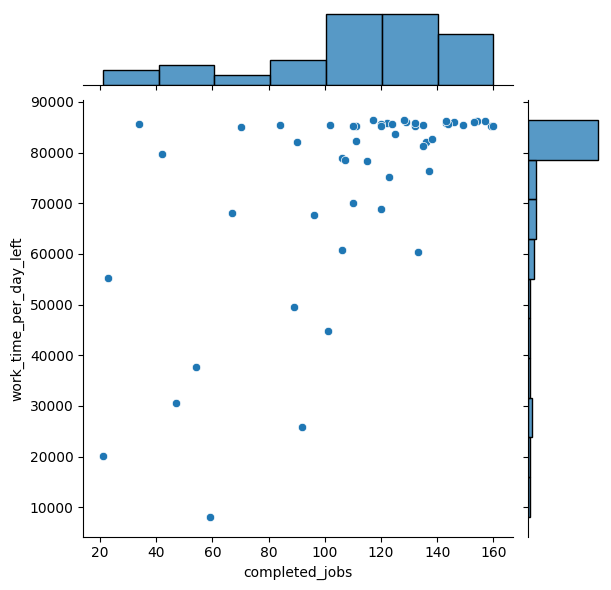

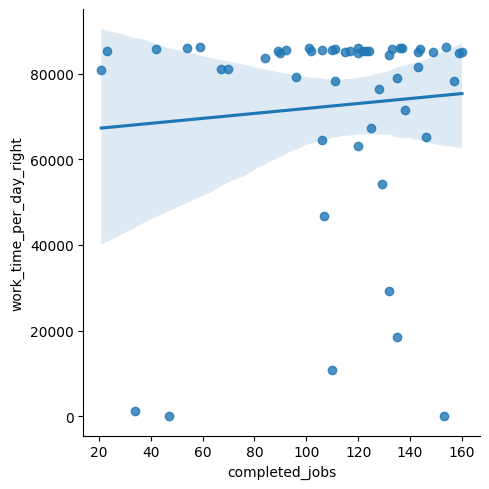

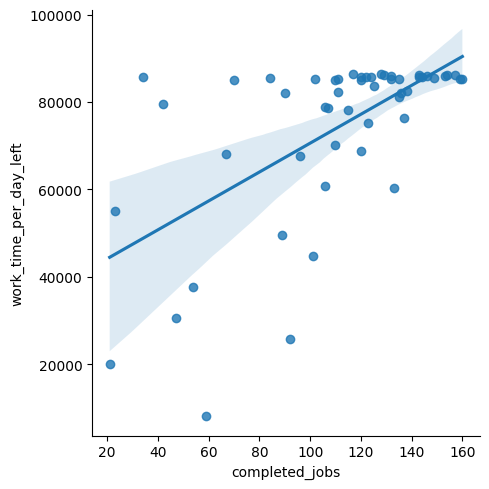

In [30]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

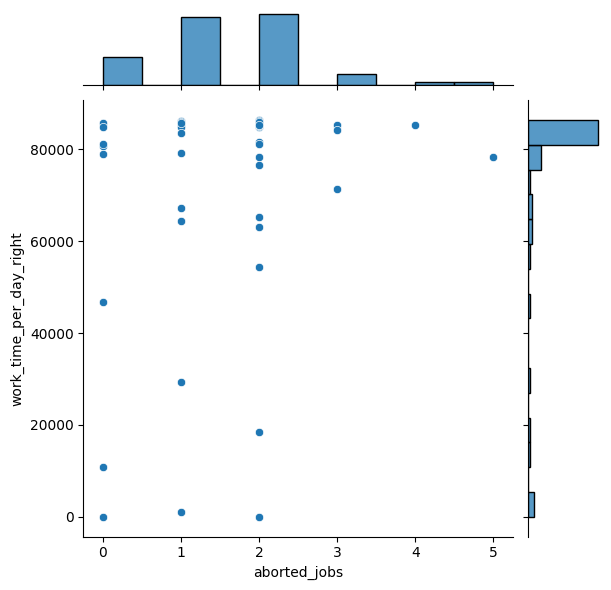

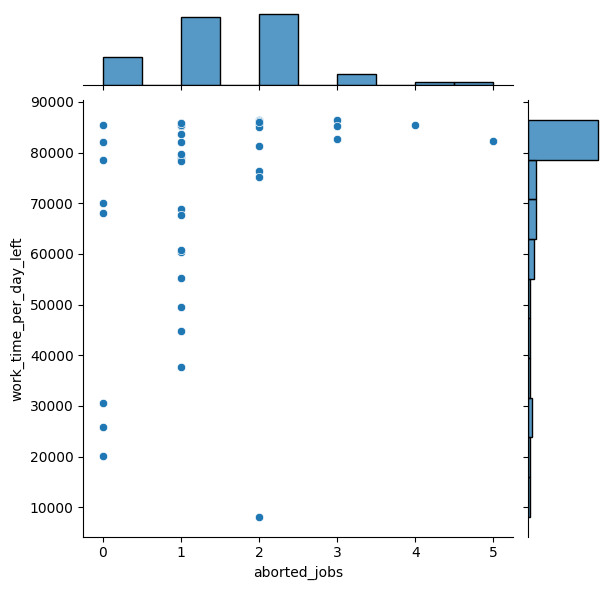

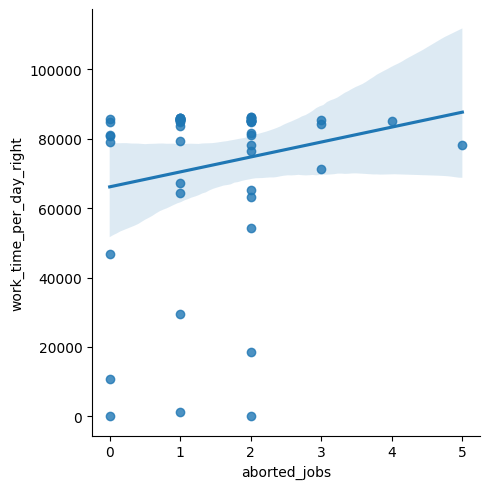

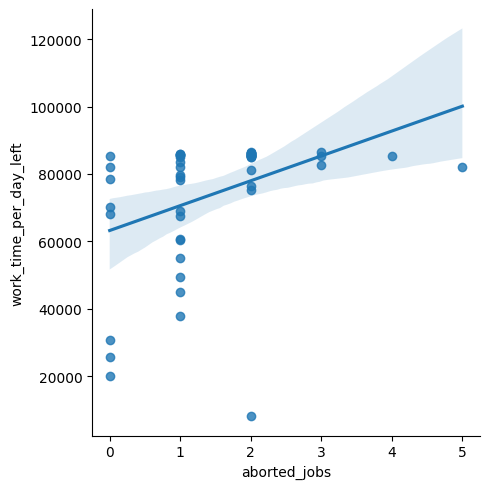

In [31]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)

#### Ideally it should be better to check by arm instead of the enitire miachine at the moment, and apply a regression method to understand the correlation between the barcode processed and the completed cycles

#### fist check the right side

In [32]:
# the data that are more correlated are the tyre per day and the completed jobs.
print(mach_processed_df.columns)

check_corr = mach_processed_df.drop(['day'], axis=1).corr()
check_corr

Index(['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right', 'completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs'], dtype='object')


,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
tyre_per_day,1.000000,0.861669,0.119716,0.619878,0.613843,0.088268,0.861159,0.302728,NaN,0.119872,0.043123,NaN,0.999657,0.398778,NaN
tyre_per_day_left,0.861669,1.000000,-0.062679,0.439776,0.702040,-0.027327,0.999580,0.345754,NaN,-0.061401,-0.070064,NaN,0.861666,0.333389,NaN
tyre_per_day_right,0.119716,-0.062679,1.000000,0.333813,0.001286,0.886237,-0.064741,0.045957,NaN,0.999661,0.417531,NaN,0.114815,0.217975,NaN
work_time_per_day,0.619878,0.439776,0.333813,1.000000,0.599332,0.212456,0.435695,0.278197,NaN,0.335471,0.077524,NaN,0.615357,0.398109,NaN
work_time_per_day_left,0.613843,0.702040,0.001286,0.599332,1.000000,-0.015894,0.697361,0.384645,NaN,0.002791,-0.052067,NaN,0.609530,0.388525,NaN
work_time_per_day_right,0.088268,-0.027327,0.886237,0.212456,-0.015894,1.000000,-0.029238,0.052800,NaN,0.885152,0.397459,NaN,0.084150,0.178413,NaN
completed_jobs_left,0.861159,0.999580,-0.064741,0.435695,0.697361,-0.029238,1.000000,0.318412,NaN,-0.063628,-0.065141,NaN,0.861792,0.310904,NaN
aborted_jobs_left,0.302728,0.345754,0.045957,0.278197,0.384645,0.052800,0.318412,1.000000,NaN,0.051721,-0.182668,NaN,0.282130,0.838646,NaN
not_started_jobs_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
completed_jobs_right,0.119872,-0.061401,0.999661,0.335471,0.002791,0.885152,-0.063628,0.051721,NaN,1.000000,0.393749,NaN,0.114880,0.221225,NaN


In [59]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def svr_regression(x,y):
    print("Model: SVR")
    model = SVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model 

def grad_boost(x, y):
    print("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
    X_test = scaler.fit_transform(X_test.values.reshape(-1,1))
    y_test = scaler.fit_transform(y_test.values.reshape(-1,1))
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    return model

In [60]:
#split data into train and test
from sklearn.model_selection import train_test_split


right_x = mach_processed_df['tyre_per_day_right']
right_y = mach_processed_df['completed_jobs_right']



left_x = mach_processed_df['tyre_per_day_left']
left_y = mach_processed_df['completed_jobs_left']



model = evaluations(right_x, right_y, lin_regr)
model = evaluations(right_x, right_y, svr_regression)
model = evaluations(right_x, right_y, grad_boost)

model = evaluations(left_x, left_y, lin_regr)
model = evaluations(left_x, left_y, svr_regression)
model = evaluations(left_x, left_y, grad_boost)



Model: Linear Regression
Model score: 0.9992976091077319
Metrics are: Accuracy: 0.9987902954833391
 MSE: 0.0008553908804999241 
 R2: 0.9987902954833391


Model: SVR
Model score: 0.9755611083628796
Metrics are: Accuracy: 0.9702554756093427
 MSE: 0.021032569985607406 
 R2: 0.9702554756093427


Model: Gradient Boosting
Model score: 0.9996102219925085
Metrics are: Accuracy: 0.9910165298876145
 MSE: 0.006352277191283908 
 R2: 0.9910165298876145


Model: Linear Regression
Model score: 0.9990602027204232
Metrics are: Accuracy: 0.9953033599327668
 MSE: 0.0014595639665355709 
 R2: 0.9953033599327668


Model: SVR
Model score: 0.9551826112380607
Metrics are: Accuracy: 0.919895077629626
 MSE: 0.02489402137703153 
 R2: 0.919895077629626


Model: Gradient Boosting
Model score: 0.9997488436129998
Metrics are: Accuracy: 0.9872735306076974
 MSE: 0.003954975446343956 
 R2: 0.9872735306076974




### On entire machine


In [61]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['completed_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.9993870584635347
Metrics are: Accuracy: 0.994622298868443
 MSE: 0.003154596234497033 
 R2: 0.994622298868443


Model: SVR
Model score: 0.9728882266459307
Metrics are: Accuracy: 0.9765209984829456
 MSE: 0.013772942743288153 
 R2: 0.9765209984829456


Model: Gradient Boosting
Model score: 0.999788044614812
Metrics are: Accuracy: 0.9868126543605825
 MSE: 0.007735787073216009 
 R2: 0.9868126543605825




### evaluate the correlation between the aborted jobs and the tyre produced

In [62]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['aborted_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.24496092497365474
Metrics are: Accuracy: -0.7824940861053173
 MSE: 1.4482764449605703 
 R2: -0.7824940861053173


Model: SVR
Model score: 0.324700499370032
Metrics are: Accuracy: -0.834832564183936
 MSE: 1.490801458399448 
 R2: -0.834832564183936


Model: Gradient Boosting
Model score: 0.7358031901584886
Metrics are: Accuracy: -1.8498040620553007
 MSE: 2.3154658004199318 
 R2: -1.8498040620553007


